In [1]:
# In this assingnment, we will be using Pandas dataframes
# to read, transform, and store MNIST images. Make sure
# you are familiar with its API:
# https://pandas.pydata.org/pandas-docs/stable/

import pandas as pd

In [2]:
# Enter here the Dataset ID that you have received in the spreadsheet.
# Make sure that you use the ID that was assigned to you, 
# otherwise your submission will be graded against the wrong images.
dataset_id = '20220924-233721_6da7e90eeb31a53677cda78f13f952d4'

# Assignment datasets are stored in an AWS S3 bucket. The following code
# downloads your dataset (~300MB) directly into RAM. Optionally,
# you can save the datasets to the local disk, but that's really not required.
prefix = f'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/mnist/jobs/transform_repack/{dataset_id}'

# These three dataframes contain clean images. Use each dataframe
# to train, validate, and test your model, respectively.
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_x.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_x.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_x.parquet')

# These dataframes are noisy versions of the dataframes above.
train_noisy_X = pd.read_parquet(f'{prefix}/train_noisy_x.parquet')
validate_noisy_X = pd.read_parquet(f'{prefix}/validate_noisy_x.parquet')
test_noisy_X = pd.read_parquet(f'{prefix}/test_noisy_x.parquet')

# This is the segment of the dataset that will be graded in this assignment.
# Your model has to denoise this dataframe, and you have to submit the denoised version of this dataframe.
score_noisy_X = pd.read_parquet(f'{prefix}/score_noisy_x.parquet')

# For additional context, these are labels (e.g. digits) corresponding
# to each image in the dataset. Use it to analyze which digits
# your models has more or less problems with. These dataframes
# should not be used as part of the training process itself,
# only for post-training analysis, if you wish so.
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [3]:
# While not strictly required for this assignment,
# you will probably want to plot images to
# have a visual understanding of the model's performance.
# You can use any Python plotting library, for example:
# https://matplotlib.org/contents.html

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [4]:
# Just as in the lecture slides, the input matrix
# has row vectors that hold pixels of a single 28x28 image.
# Note that the column vectors are individual locations on
# the 28x28 grid, but flattened in a row-major way (28x28=784).
train_clean_X.shape

(49000, 784)

In [5]:
example_id = 1

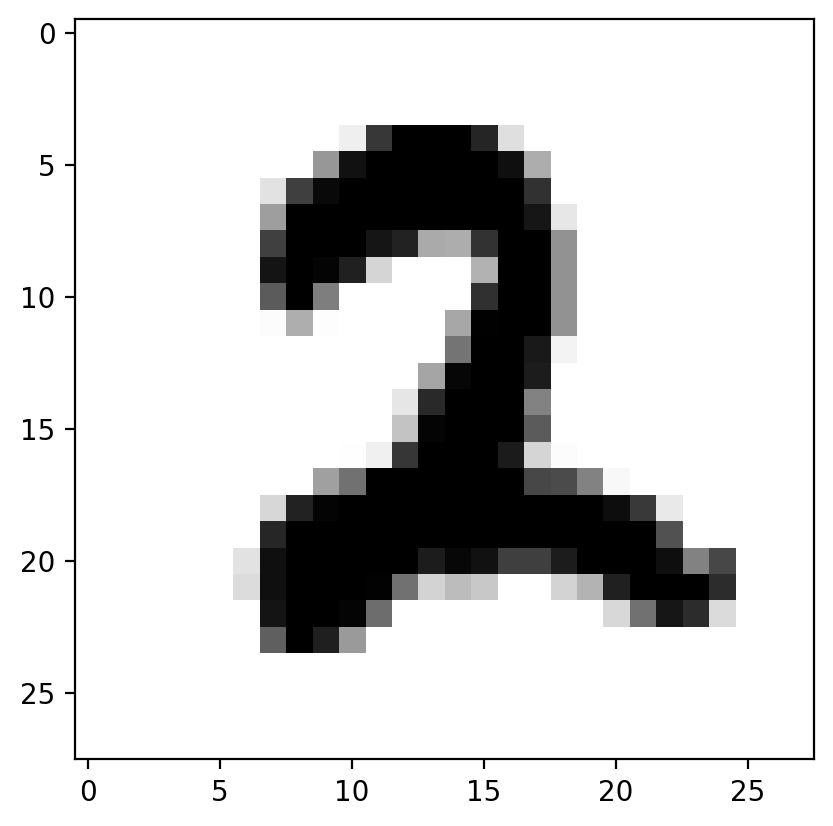

In [6]:
# Let's select a clean image from the dataset
image_pixels = train_clean_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

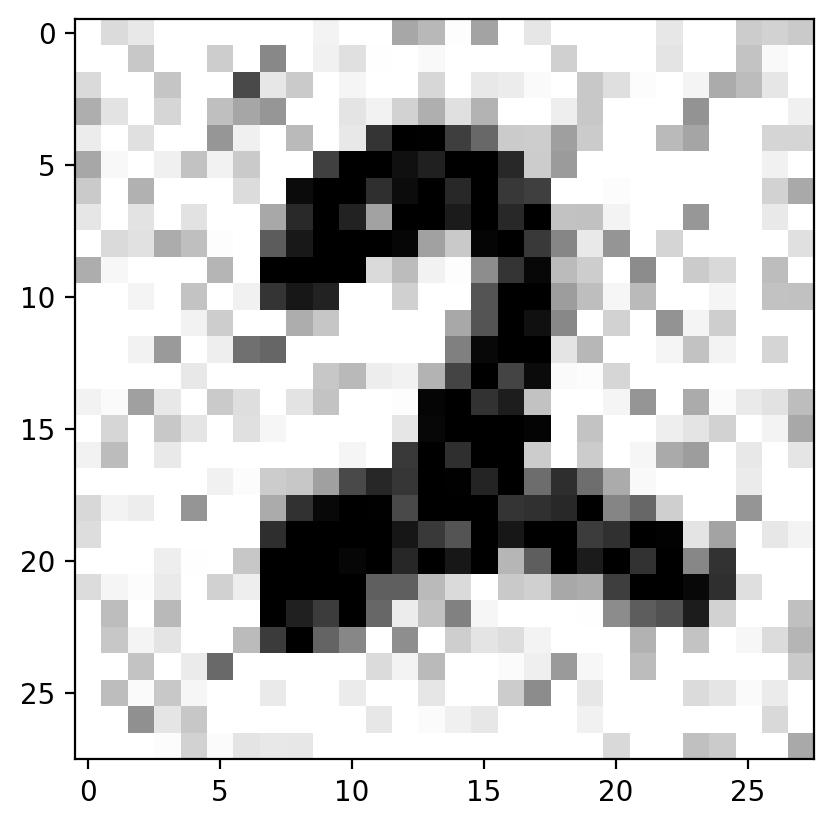

In [7]:
# Let's select a noisy image from the dataset
image_pixels = train_noisy_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

In [8]:
train_y.iloc[example_id]

digit    2
Name: 1, dtype: uint8

In [9]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

2022-10-02 22:52:57.662004: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-02 22:52:57.662077: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-50-211): /proc/driver/nvidia/version does not exist


In [117]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras_tuner.engine.hyperparameters import HyperParameters

def build_model(hp: HyperParameters) -> tf.keras.Model:
    
    # IMPORTANT: This is an example of a very simple undercomplete autoencoder.
    # In other words, you will probably need to tweak these lines of code.
    
    layers = [
        # Encoder: 50 nodes, Exponential Linear Unit activation
        Dense(
            units=hp.Int('encoder_width', min_value=200, max_value=256, step=4), 
            input_shape=(28 * 28,)
        ),
        
        BatchNormalization(),
        LeakyReLU(),        
        
        Dense(units=128, activation='tanh', activity_regularizer=regularizers.L1(1e-4)),

        # Decoder: matches the shape of the image
        # Sigmoid activation is needed because pixel
        # values are real numbers between 0 (black) and 1 (white).
        
        Dense(
            units=hp.Int('encoder_width', min_value=200, max_value=256, step=4), 
    
        ),
        BatchNormalization(),
        LeakyReLU(),
        Dense(units=28*28, activation='sigmoid')
    ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(
            learning_rate=hp.Float(name='learning_rate', min_value=1e-4, max_value=1e-3, sampling='log')
        ), 
        loss='mean_squared_error'
    )
    
    return autoencoder

In [118]:
# IMPORTANT: This is an example of a reconstruction training mode.
# Your autoencoder has to be trained in denoising mode.
# In other words, you will probably need to tweak these lines of code.

def train_model(model: tf.keras.Model, epochs: int) -> tf.keras.callbacks.History:
    history = model.fit(
        x=train_noisy_X, #train_clean_X, 
        y=train_clean_X, 

        # It's a good idea to have low number of epochs,
        # to test the learning process, but not for the final model training.
        epochs=epochs,

        batch_size=128,
        shuffle=True,
        validation_data=(validate_noisy_X, validate_clean_X)
    )
    return history

In [91]:
# In order to have reproducible results, we need
# to set the seed values for NumPy and Tensorflow.
# Keep these lines in the same cell as the training code,
# so that you don't accidentally train multiples models
# without reseting the seed.

import numpy as np
import tensorflow as tf

np.random.seed(11)
tf.random.set_seed(11)

hp = HyperParameters()
hp.Fixed('encoder_width', value=224)
hp.Fixed('learning_rate', value=1e-3)

autoencoder = build_model(hp)
history = train_model(autoencoder, epochs=10)

Epoch 1/10
383/383 [==============================] - 4s 8ms/step - loss: 0.0329 - val_loss: 0.0169
Epoch 2/10
383/383 [==============================] - 3s 7ms/step - loss: 0.0120 - val_loss: 0.0105
Epoch 3/10
383/383 [==============================] - 3s 7ms/step - loss: 0.0097 - val_loss: 0.0089
Epoch 4/10
383/383 [==============================] - 3s 7ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 5/10
383/383 [==============================] - 3s 7ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 6/10
383/383 [==============================] - 3s 7ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 7/10
383/383 [==============================] - 3s 7ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 8/10
383/383 [==============================] - 3s 7ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 9/10
383/383 [==============================] - 3s 7ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 10/10
383/383 [==============================] - 3s 7ms/step - loss: 0.0065 - val_loss: 0.0065

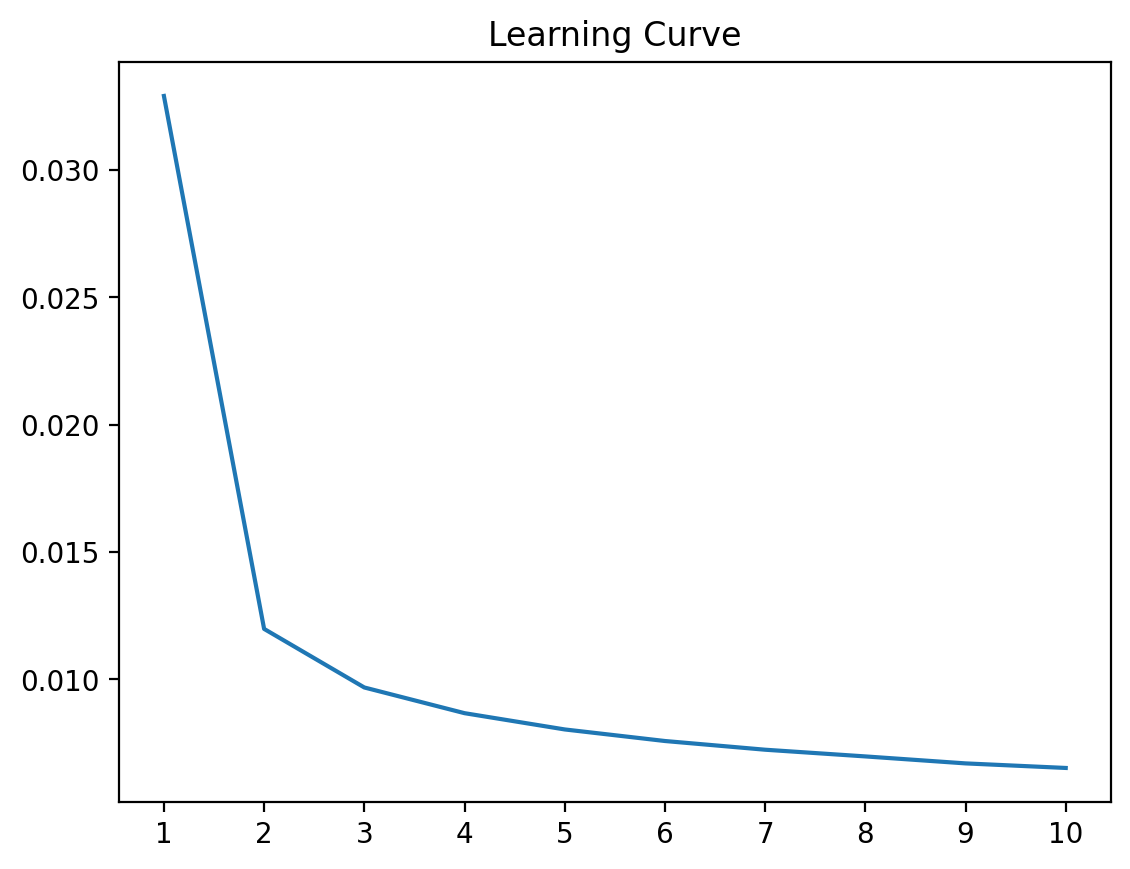

In [92]:
# The fit method returns a history object that
# can be used to plot the learning curve.

learning_curve = pd.Series(history.history['loss'])
learning_curve.index = learning_curve.index + 1

learning_curve.plot(title='Learning Curve')
plt.xticks(learning_curve.index)
plt.show()

In [119]:
from keras_tuner.tuners import RandomSearch

# A tuner implements a particular hyperoptimization strategy.
# This example uses a random search turner, which samples
# hyperparameter values from the distributions specified
# in the build_model function. You can use other tuners too:
# https://keras-team.github.io/keras-tuner/documentation/tuners/

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='denoiser_hyperop',
    seed=11,
    
    # Experiment name must change if you modify
    # the model structure or the set of hyperparameters.
    project_name='autoencoder_42'
)

# This displays which hyperparameters are tunable, and their respective distribution.
tuner.search_space_summary()

Search space summary
Default search space size: 2
encoder_width (Int)
{'default': None, 'conditions': [], 'min_value': 200, 'max_value': 256, 'step': 4, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [120]:
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)

# IMPORTANT: This is an example of a reconstruction training mode.
# Your autoencoder has to be trained in denoising mode.
# In other words, you will probably need to tweak these lines of code.

tuner.search(    
    # All parameters here are passed thru to Model.fit function.
    x=train_noisy_X, #train_clean_X, 
    y=train_clean_X, 
    
    # It's a good idea to have low number of epochs,
    # to test the learning process, but not for the final model training.
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(validate_noisy_X, validate_clean_X)
)

Trial 20 Complete [00h 00m 29s]
val_loss: 0.007844898849725723

Best val_loss So Far: 0.006755003705620766
Total elapsed time: 00h 10m 51s
INFO:tensorflow:Oracle triggered exit


In [160]:
# The following function can be used to view the search summary.
#tuner.results_summary()

In [130]:
# The tuner's oracle property can be used to fetch information
# about every trial, which can be used to build a table like so.

pd.DataFrame([
    {
        'trial_id': t.trial_id,
        'score': t.score,
        **t.hyperparameters.values 
    }
    for t in tuner.oracle.get_best_trials(num_trials=20)
]).set_index('trial_id')

,score,encoder_width,learning_rate
trial_id,,,
17,0.006755,216,0.000773
04,0.006817,236,0.000805
05,0.006819,208,0.000908
06,0.007005,252,0.000516
07,0.007115,220,0.000559
13,0.007249,240,0.000436
15,0.007291,220,0.000436
11,0.007428,232,0.000338
09,0.007430,232,0.000346


In [143]:
# This returns the best model found during the search.
# autoencoder = tuner.get_best_models(num_models=1)[0]

In [121]:
# You can proceed with the above model, but it might 
# be also a good idea to do a final training pass with the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_hyperparameters.values
# autoencoder = build_model(best_hyperparameters)

{'encoder_width': 216, 'learning_rate': 0.0007731576839806804}

In [122]:
np.random.seed(11)
tf.random.set_seed(11)
autoencoder = build_model(best_hyperparameters)
autoencoder.fit(x=train_noisy_X, #train_clean_X, 
        y=train_clean_X, 

        # It's a good idea to have low number of epochs,
        # to test the learning process, but not for the final model training.
        epochs=100,

        batch_size=128,
        shuffle=True,
        validation_data=(validate_noisy_X, validate_clean_X))

Epoch 1/100
383/383 [==============================] - 4s 8ms/step - loss: 0.0383 - val_loss: 0.0198
Epoch 2/100
383/383 [==============================] - 3s 8ms/step - loss: 0.0133 - val_loss: 0.0115
Epoch 3/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0104 - val_loss: 0.0096
Epoch 4/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 5/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 6/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 7/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 8/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 10/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0068 - val_lo

In [123]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder.predict(train_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

In [124]:
# Get denoised images for validation set.
validate_denoised_X = autoencoder.predict(validate_noisy_X)
validate_denoised_X = pd.DataFrame(validate_denoised_X)

In [125]:
# Get denoised images for test set.
test_denoised_X = autoencoder.predict(test_noisy_X)
test_denoised_X = pd.DataFrame(test_denoised_X)

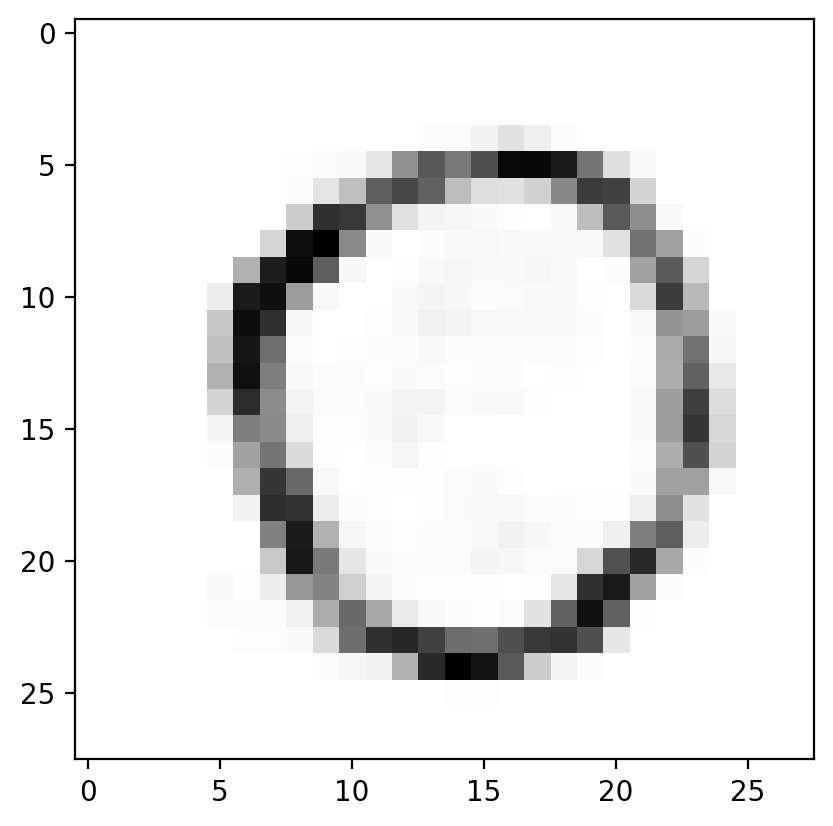

In [126]:
# Let's confirm that the denoiser works.
image_pixels = validate_denoised_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [127]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(validate_denoised_X, validate_clean_X)

0.00426705

In [128]:
mean_squared_error(test_denoised_X, test_clean_X)

0.0042458693

In [131]:
import os 

model_dir = 'denoiser_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the autoencoder on the score noisy dataset.
score_denoised_X = pd.DataFrame(
    autoencoder.predict(score_noisy_X),
    # This is needed to save the file in Parquet format.
    columns=score_noisy_X.columns
)

# Now save it to disc as a Parquet file.
score_denoised_X.to_parquet(f'{model_dir}/score_denoised_x.parquet')

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    f.write(json.dumps(json.loads(autoencoder.to_json()), indent=True))

# Finally, let's save the learned parameters.
autoencoder.save_weights(f'{model_dir}/keras_parameters.h5')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.h5 -- the model's trained parameters
# 4. score_denoised_X.parquet - the model's output on the score dataset

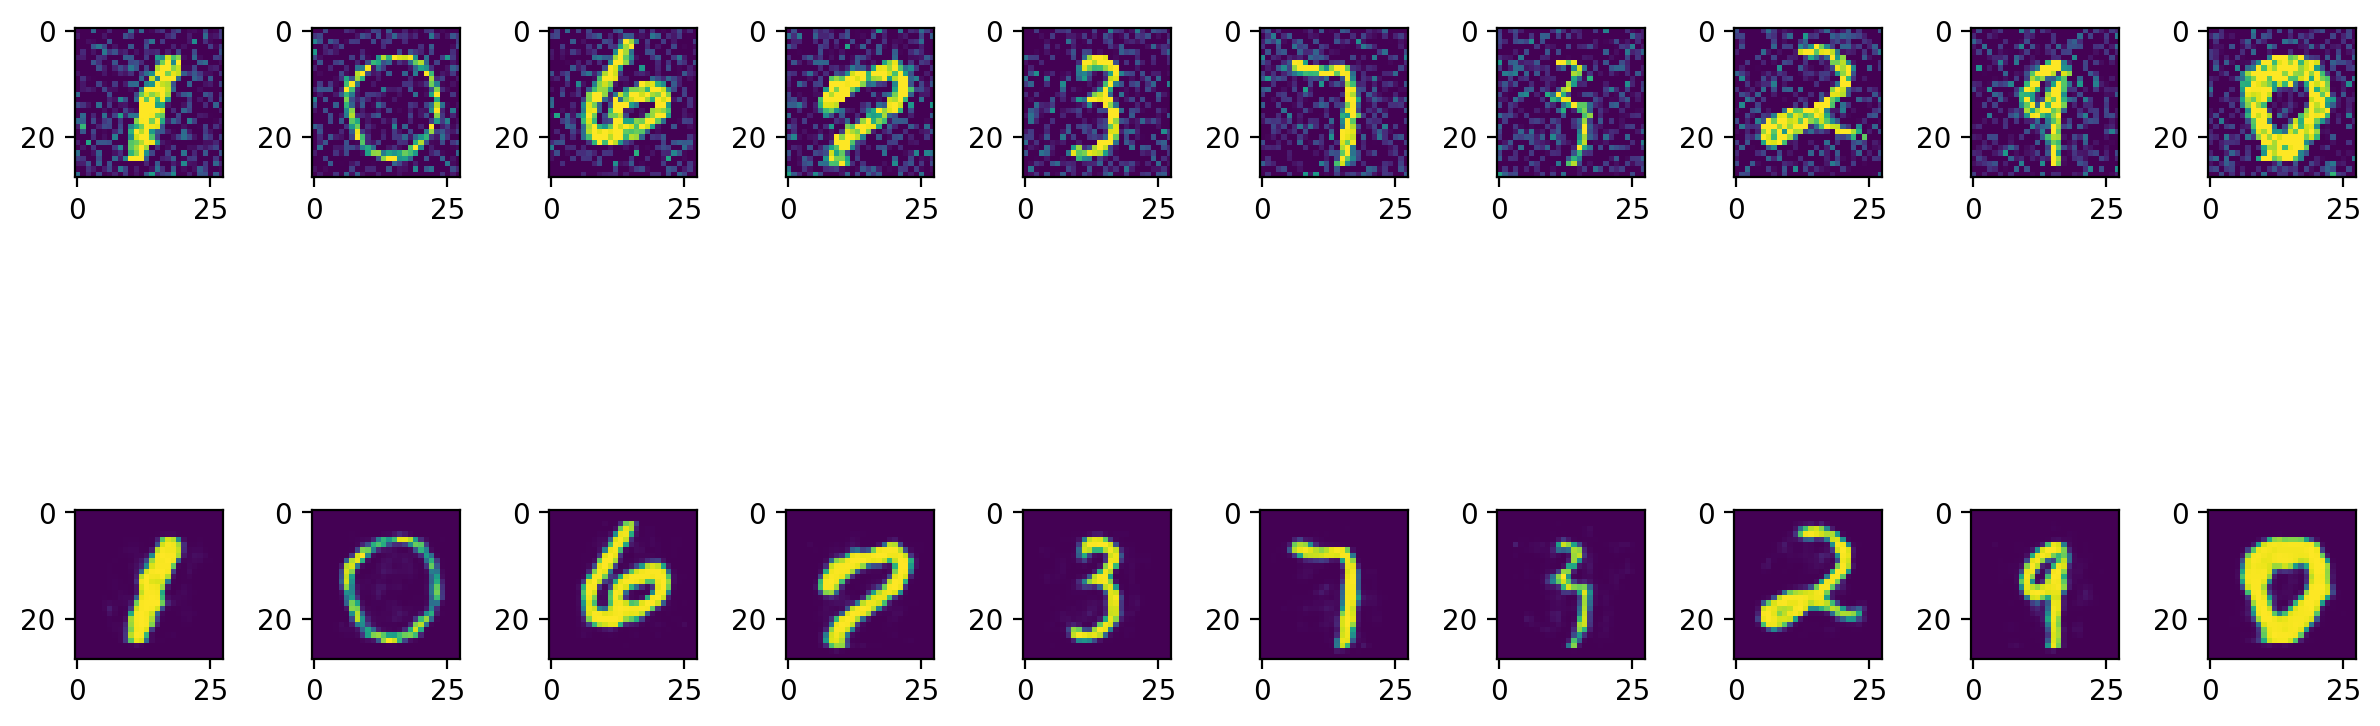

In [132]:
n=10
fig, axs = plt.subplots(2, n, sharey=False, tight_layout=True, figsize=(12,6))

for i in range(n):
    axs[0,i].imshow(validate_noisy_X.iloc[i].values.reshape(28, 28))
    axs[1,i].imshow(validate_denoised_X.iloc[i].values.reshape(28, 28))

plt.show() 

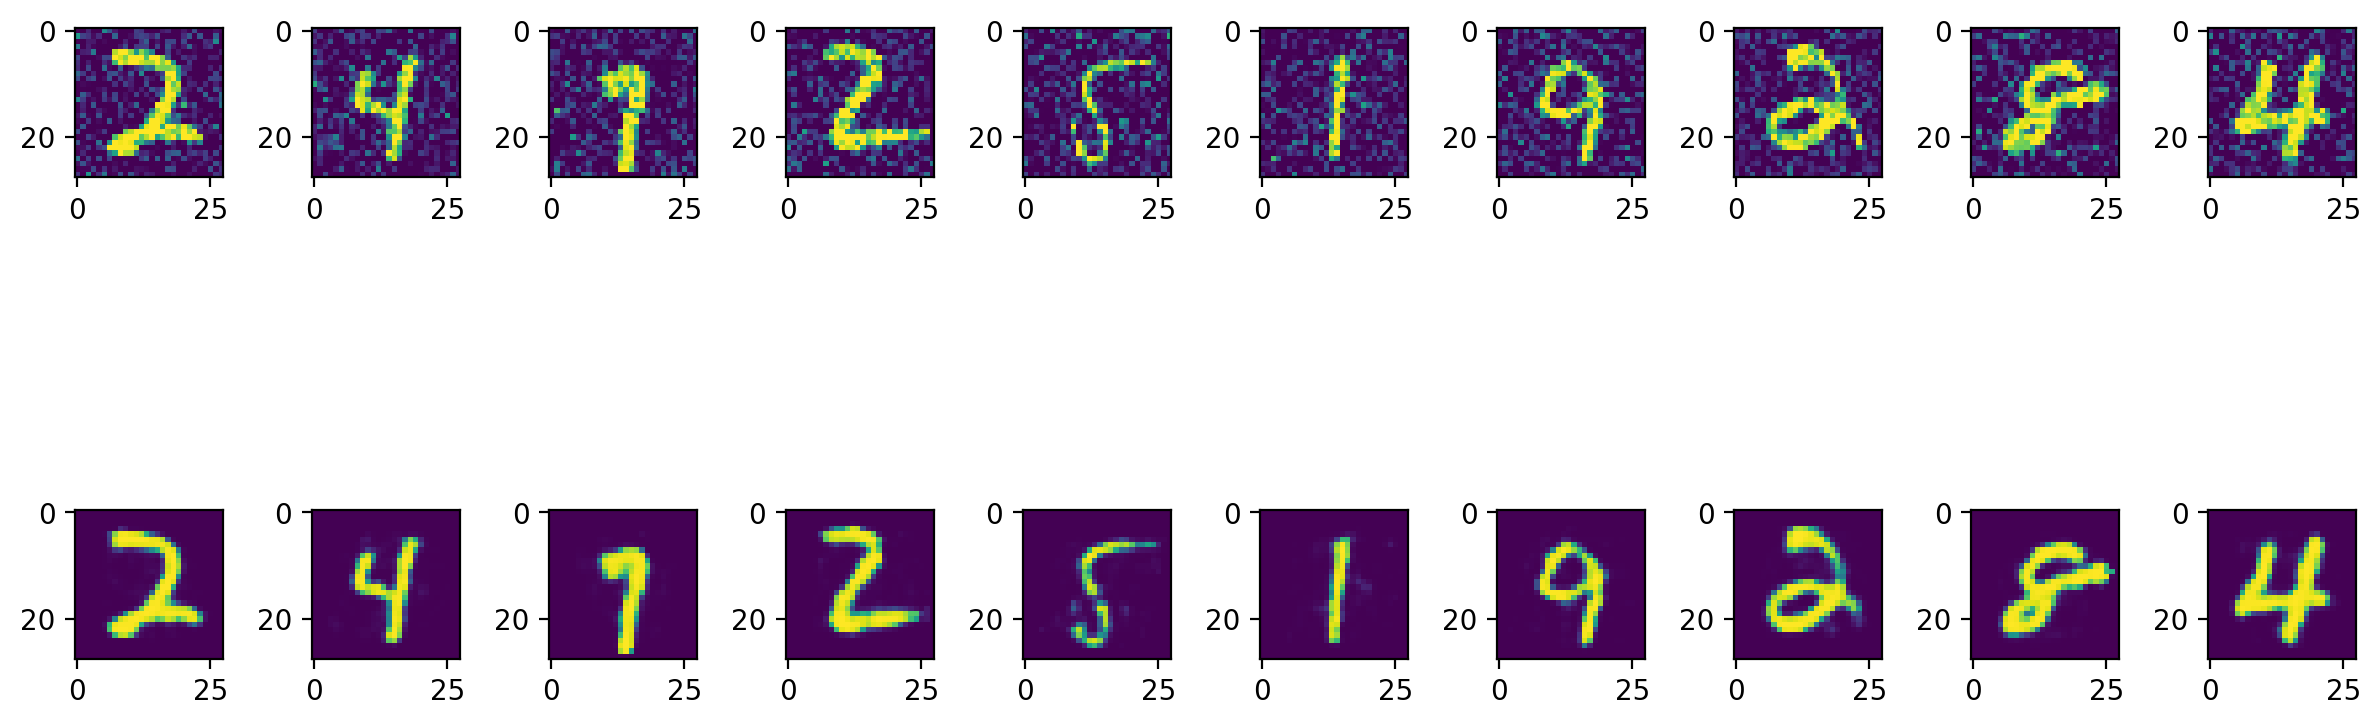

In [133]:
n=10
fig, axs = plt.subplots(2, n, sharey=False, tight_layout=True, figsize=(12,6))

for i in range(n):
    axs[0,i].imshow(score_noisy_X.iloc[i].values.reshape(28, 28))
    axs[1,i].imshow(score_denoised_X.iloc[i].values.reshape(28, 28))

plt.show() 